<a href="https://colab.research.google.com/github/niha21ah/ml-project/blob/nils/Copy_of_ML_end_project-6-5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Project

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# ml models
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [23]:
per = pd.read_csv('/content/Perth.csv')

---
# 1. EDA and Feature Engineering



Content:


*   Discuss Class imbalance
*   Scale
*   Plot




In [24]:
print(per.shape)
print(per.columns)
per.head()

(36043, 149)
Index(['X1', 'Y1', 'X2', 'Y2', 'X3', 'Y3', 'X4', 'Y4', 'X5', 'Y5',
       ...
       'Power42', 'Power43', 'Power44', 'Power45', 'Power46', 'Power47',
       'Power48', 'Power49', 'qW', 'Total_Power'],
      dtype='object', length=149)


,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,...,Power42,Power43,Power44,Power45,Power46,Power47,Power48,Power49,qW,Total_Power
0,600.0,0.0,546.16,37.50,489.79,74.88,432.47,112.05,650.0,0.0,...,88867.92,98844.30,101283.59,98934.63,101624.58,100915.03,99625.68,96704.34,0.87,4102461.43
1,593.0,12.0,546.16,37.50,489.79,74.88,432.47,112.05,644.0,8.0,...,88896.55,98759.79,101346.07,98873.59,101629.01,100934.53,99606.13,96718.39,0.87,4103361.41
2,593.0,12.0,546.16,37.50,489.79,74.88,432.47,112.05,644.0,8.0,...,88919.83,98746.68,101346.15,98875.57,101618.32,100941.00,99611.35,96719.14,0.87,4103680.44
3,593.0,12.0,546.16,37.50,489.79,74.88,432.47,112.05,644.0,8.0,...,88855.14,98760.96,101338.59,98971.58,101632.28,100943.59,99589.25,96735.04,0.87,4105661.06
4,200.0,0.0,146.17,37.53,89.76,74.93,32.40,112.18,400.0,0.0,...,88005.30,98630.24,100432.73,98803.01,101064.48,100948.38,99028.87,96286.71,0.79,3752648.77


In [25]:
#Checking if Total_power is the sum of all power outputs:
power_cols = per.filter(regex = r'^Pow').columns


In [26]:
power_cols

Index(['Power1', 'Power2', 'Power3', 'Power4', 'Power5', 'Power6', 'Power7',
       'Power8', 'Power9', 'Power10', 'Power11', 'Power12', 'Power13',
       'Power14', 'Power15', 'Power16', 'Power17', 'Power18', 'Power19',
       'Power20', 'Power21', 'Power22', 'Power23', 'Power24', 'Power25',
       'Power26', 'Power27', 'Power28', 'Power29', 'Power30', 'Power31',
       'Power32', 'Power33', 'Power34', 'Power35', 'Power36', 'Power37',
       'Power38', 'Power39', 'Power40', 'Power41', 'Power42', 'Power43',
       'Power44', 'Power45', 'Power46', 'Power47', 'Power48', 'Power49'],
      dtype='object')

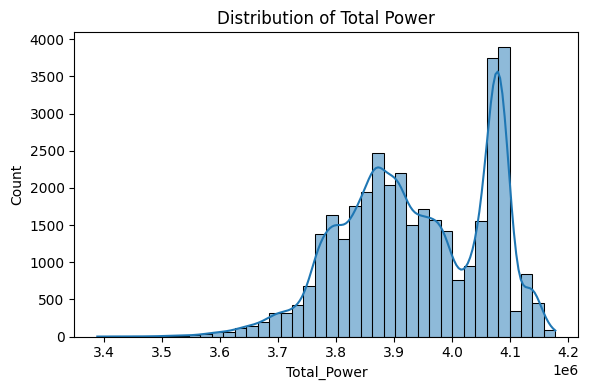

In [27]:
plt.figure(figsize=(6,4))
sns.histplot(per['Total_Power'], kde=True, bins=40)
plt.title("Distribution of Total Power")
plt.xlabel("Total_Power")
plt.tight_layout()
plt.show()

In [28]:
# Feature Engineering for later use


# Benchmark Linear Regression


In [29]:
# Function for K Fold

def KFOLD_test_pipeline(pipeline, n_splits, X, y, scaled = False, target_scaler = None, model_name = None, results_dict = None):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    rmse_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val).reshape(-1,1)

        if scaled and target_scaler is not None:
            y_pred = target_scaler.inverse_transform(y_pred)
            y_val = target_scaler.inverse_transform(y_val.reshape(-1,1))

        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    mean_rmse = np.mean(rmse_scores)

    if model_name:
        print(f'{model_name}: Mean RMSE = {mean_rmse}')
    else:
        print(f'Mean RMSE = {mean_rmse}')

    if results_dict is not None and model_name:
        results_dict[model_name] = mean_rmse

    rmse_scores = [float(val) for val in rmse_scores]
    return rmse_scores


In [30]:
# Function for plotting pred vs actual

def plot_predictions(y_true, y_pred, model_name):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()],
             [y_true.min(), y_true.max()],
             'r--', label='Ideal fit')
    plt.xlabel("Actual Total Power")
    plt.ylabel("Predicted Total Power")
    plt.title(f"{model_name}: Predicted vs Actual")
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

In [31]:
# selecting features and target
cols = [col for col in per.columns if col.startswith(('X', 'Y'))]
X = per[cols]
y = per['Total_Power']

In [32]:
# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# pipelined linear regression (unscaled)
pipe_linr = Pipeline([
    ('model', LinearRegression())
])

KFOLD_test_pipeline(pipeline=pipe_linr, n_splits=5, X=X_train, y=y_train)

Mean RMSE = 50658.282915290634


[51135.352756297536,
 51090.15057510988,
 50445.835402717785,
 50946.209748544694,
 49673.86609378325]

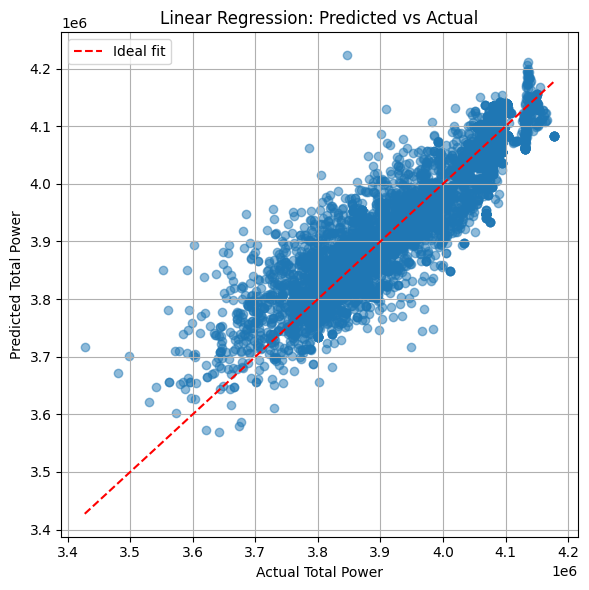

In [34]:
pipe_linr.fit(X_train, y_train)
y_pred_linr = pipe_linr.predict(X_test)

plot_predictions(y_test, y_pred_linr, 'Linear Regression')

Attempt for improval: scaling features
(although Linear Regression is not sensitive to scale differences, it can improve the results, and for comparability reasons

In [35]:
# pipelined linear regression with scaled data

pipe_linr_scaled = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

KFOLD_test_pipeline(pipeline=pipe_linr_scaled, n_splits=5, X=X_train, y=y_train, scaled=True)

Mean RMSE = 50658.28291529063


[51135.35275629755,
 51090.15057510989,
 50445.83540271776,
 50946.20974854467,
 49673.86609378326]

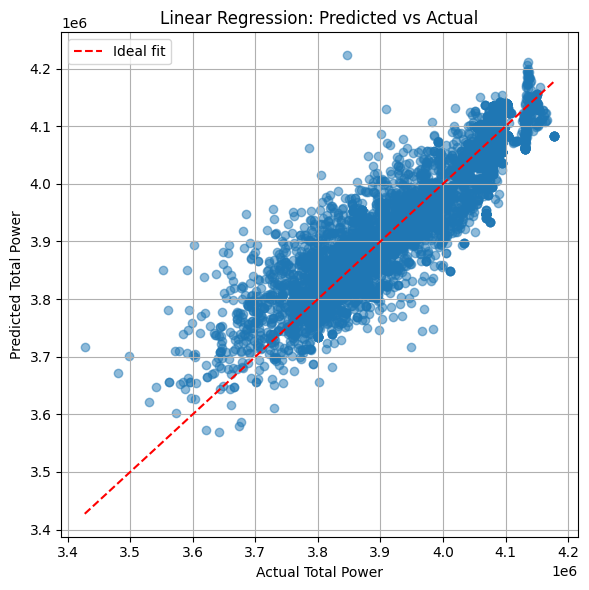

In [36]:
pipe_linr_scaled.fit(X_train, y_train)
y_pred_linr_scaled = pipe_linr_scaled.predict(X_test)

plot_predictions(y_test, y_pred_linr_scaled, 'Linear Regression')

No differences because LR is scale-invariant without regularization. Can be used as soon as Regularisation is attempted

Plot for accuracy of the prediction:
red line

Attempt 2 for improval: Ridge Regression

In [37]:
pipe_ridge = Pipeline([
    ('model', Ridge())
])

In [38]:
params_ridge = {'model__alpha': [0.1, 1.0, 10.0, 100.0]}

grid = GridSearchCV(pipe_ridge, params_ridge, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X,y)

print("Best parameters: ", grid.best_estimator_)
best_pipe_ridge = grid.best_estimator_

Best parameters:  Pipeline(steps=[('model', Ridge(alpha=100.0))])


In [39]:
KFOLD_test_pipeline(best_pipe_ridge, n_splits=5, X=X_train, y=y_train)

Mean RMSE = 50658.278117898895


[51135.346492750046,
 51090.15013865114,
 50445.84156300947,
 50946.18310623653,
 49673.86928884729]

In [40]:
best_pipe_ridge.get_params()

{'memory': None,
 'steps': [('model', Ridge(alpha=100.0))],
 'transform_input': None,
 'verbose': False,
 'model': Ridge(alpha=100.0),
 'model__alpha': 100.0,
 'model__copy_X': True,
 'model__fit_intercept': True,
 'model__max_iter': None,
 'model__positive': False,
 'model__random_state': None,
 'model__solver': 'auto',
 'model__tol': 0.0001}

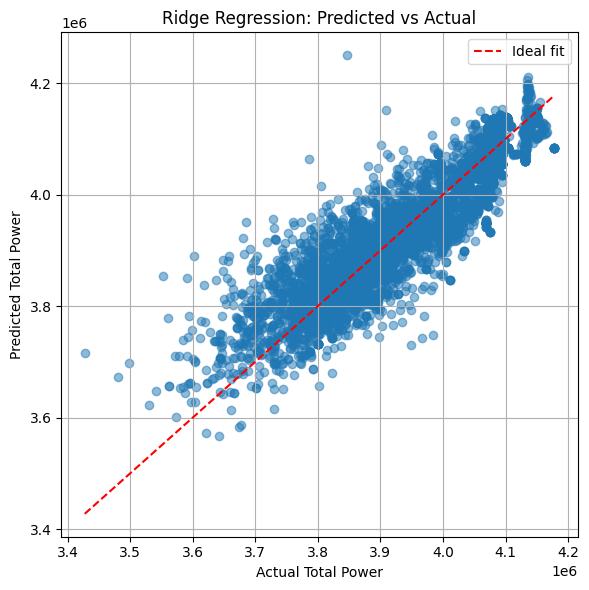

In [41]:
pipe_ridge.fit(X_train, y_train)
y_pred_ridge = best_pipe_ridge.predict(X_test)

plot_predictions(y_test, y_pred_ridge, 'Ridge Regression')

In [42]:
pipe_ridge_scaled = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())
])

In [43]:
params_ridge_scaled = {'model__alpha': [0.1, 1.0, 10.0, 100.0]}

grid = GridSearchCV(pipe_ridge_scaled, params_ridge, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X,y)

print("Best parameters: ", grid.best_estimator_)
best_pipe_ridge_scaled = grid.best_estimator_

Best parameters:  Pipeline(steps=[('scaler', StandardScaler()), ('model', Ridge(alpha=100.0))])


In [44]:
KFOLD_test_pipeline(best_pipe_ridge_scaled, n_splits=5, X=X_train, y=y_train, scaled=True)

Mean RMSE = 50644.35316494179


[51136.8870479929,
 51090.776970856576,
 50494.14870103843,
 50845.868983523294,
 49654.08412129777]

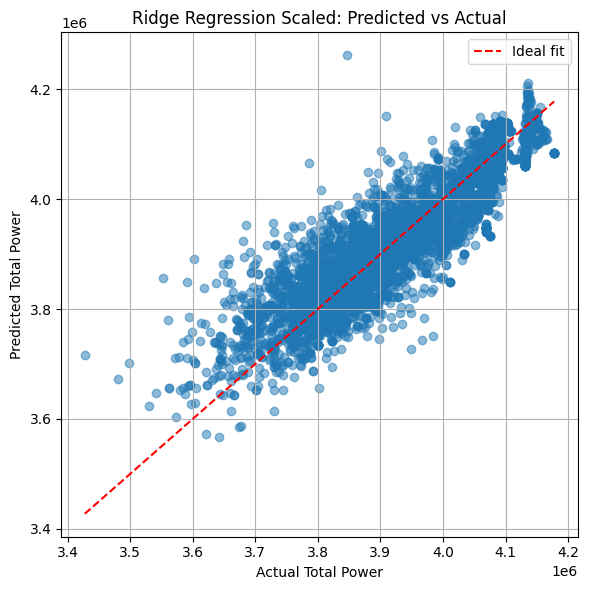

In [45]:
pipe_ridge_scaled.fit(X_train, y_train)
y_pred_ridge = best_pipe_ridge_scaled.predict(X_test)

plot_predictions(y_test, y_pred_ridge, 'Ridge Regression Scaled')

Ridge Regression is not sensitive to the scale of y, only to the scale of the input features (X), because the penalty term (α * sum(β²)) applies only to the coefficients of features — not the output.


Attempt 3 for improvement: Lasso Regression

In [46]:
pipe_lasso = Pipeline([
    ('model', Lasso())
])

In [47]:
params_lasso =  {'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid =  GridSearchCV(pipe_lasso, params_lasso, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters: ", grid.best_estimator_)
best_pipe_lasso = grid.best_estimator_

Best parameters:  Pipeline(steps=[('model', Lasso(alpha=1000))])


In [48]:
KFOLD_test_pipeline(best_pipe_lasso, n_splits=5, X=X_train, y=y_train)

Mean RMSE = 50654.14491728621


[51129.880048378116,
 51090.1547015194,
 50455.44565918997,
 50917.28970726062,
 49677.95447008296]

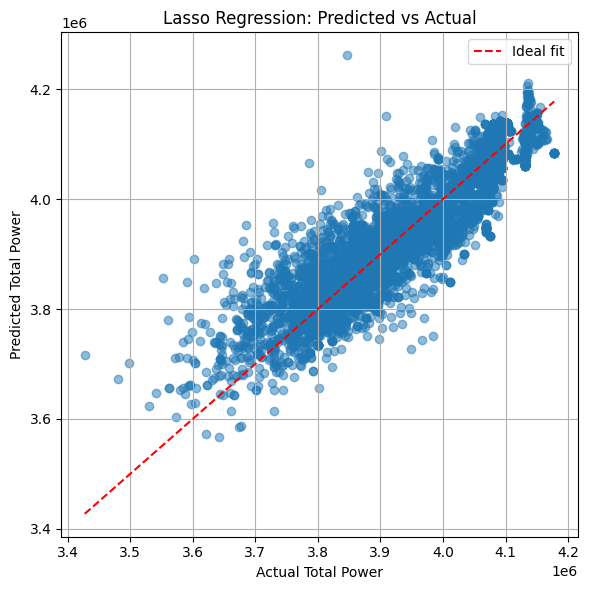

In [49]:
pipe_lasso.fit(X_train, y_train)
y_pred_ridge = best_pipe_ridge_scaled.predict(X_test)

plot_predictions(y_test, y_pred_ridge, 'Lasso Regression')

Attempt 3 for improvement: Random Forest

Why Doesn’t Random Forest Require Scaling?

Because Random Forest:

  •	Is based on decision trees

  •	Splits data by thresholds, not by distances or magnitude


In [50]:
pipe_rf = Pipeline([
    ('model', RandomForestRegressor())
])

In [51]:
KFOLD_test_pipeline(pipe_rf, n_splits=5, X=X_train, y=y_train)

Mean RMSE = 29384.607866266084


[31016.38458846701,
 28584.355689472388,
 30226.433650695446,
 28671.118647888412,
 28424.74675480715]

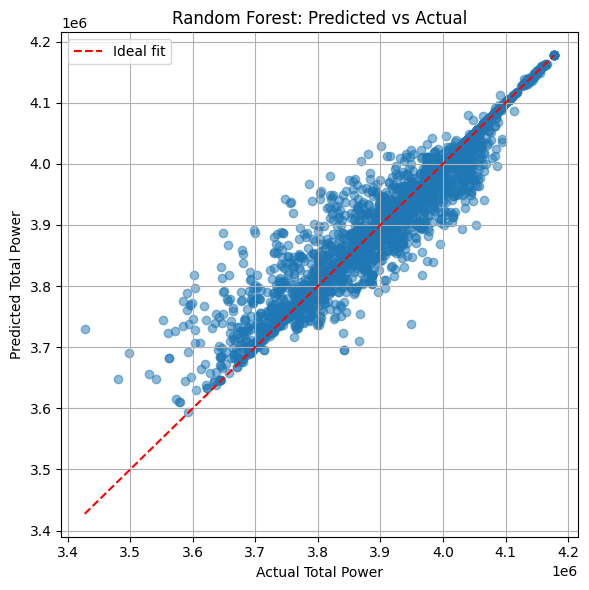

In [52]:
pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)

plot_predictions(y_test, y_pred_rf, 'Random Forest')

Using Gridsearch to find the best model

In [53]:
params = {
    'model__n_estimators': [100, 200,300],
    'model__max_depth': [10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__max_features': ['log2', 'sqrt', None]
}

#grid = GridSearchCV(pipe_rf, params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
#grid.fit(X_train, y_train)

#print("Best parameters: ", grid.best_estimator_)
best_pipe_rf = RandomForestRegressor(max_depth=20, max_features=None, n_estimators=200)

In [54]:
best_pipe_rf = RandomForestRegressor(max_depth=20, max_features=None, n_estimators=200)

RandomForestRegressor(max_depth=20, max_features=None, n_estimators=200)

In [55]:
KFOLD_test_pipeline(best_pipe_rf, n_splits=5, X=X_train, y=y_train)

Mean RMSE = 29310.24042804861


[30893.088488603666,
 28533.507750642977,
 29800.19679157701,
 28816.16179140352,
 28508.24731801588]

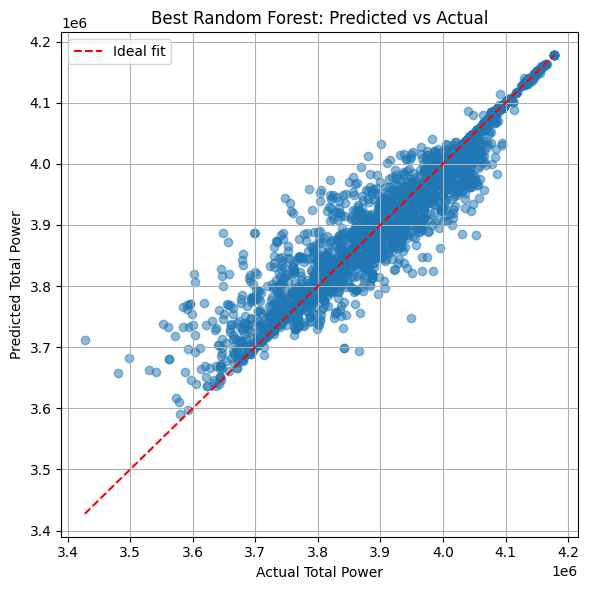

In [56]:
best_pipe_rf.fit(X_train, y_train)
y_pred_rf = best_pipe_rf.predict(X_test)

plot_predictions(y_test, y_pred_rf, 'Best Random Forest')

Best parameters:  RandomForestRegressor(max_depth=20, max_features=None, n_estimators=200)

Choices:


*   n_estimators(default=100): number of trees, more trees ->
lower variance more stable predictions
*   max_depth(default=None): controlling model complexity, balancing overfitting and
*   min_samples split(default=2)


New Approach: XGBoost

In [57]:
pipe_xgb = Pipeline([
    ('model', XGBRegressor())
])

In [58]:
KFOLD_test_pipeline(pipe_xgb, n_splits=5, X=X_train, y=y_train)

Mean RMSE = 25563.33205816626


[26772.058507874073,
 24772.91448764738,
 25686.37731577524,
 25000.410298752755,
 25584.89968078183]

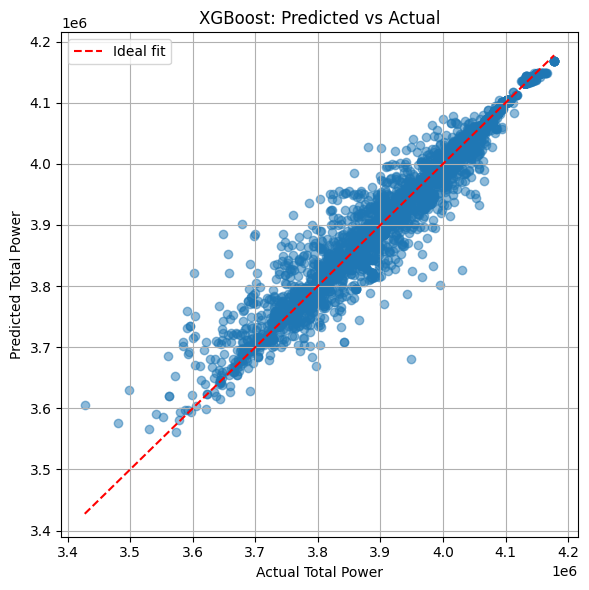

In [59]:
pipe_xgb.fit(X_train, y_train)
y_pred_xgb = pipe_xgb.predict(X_test)

plot_predictions(y_test, y_pred_xgb, 'XGBoost')

In [61]:
params_xgb = {
     'model__n_estimators': [100, 200],
    'model__max_depth': [4, 6, 8],
    'model__learning_rate': [0.01, 0.1],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0],
}

grid = GridSearchCV(pipe_xgb, params_xgb, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_train)

print('Best parameters: ', grid.best_estimator_)
best_pipe_xgb = grid.best_estimator_

Best parameters:  Pipeline(steps=[('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.8, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200,

In [62]:
KFOLD_test_pipeline(best_pipe_xgb, n_splits=5, X=X_train, y=y_train)

Mean RMSE = 24262.983555484563


[25242.186373875305,
 23920.28486870205,
 24454.547301327093,
 23633.559539208967,
 24064.3396943094]

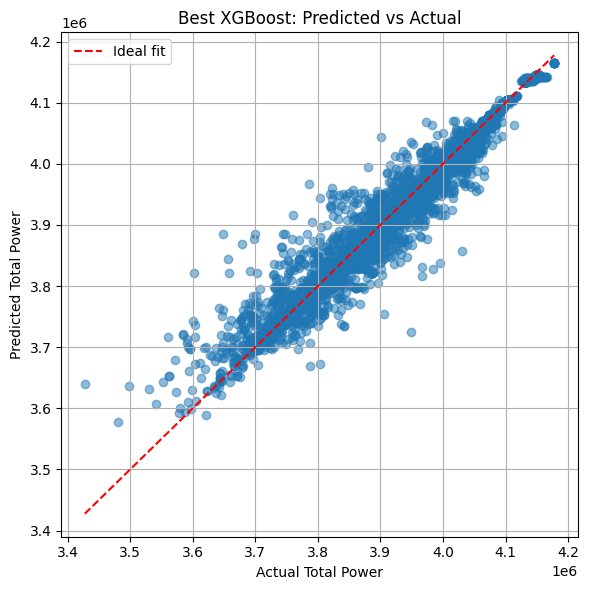

In [63]:
best_pipe_xgb.fit(X_train, y_train)
y_pred_xgb = best_pipe_xgb.predict(X_test)

plot_predictions(y_test, y_pred_xgb, 'Best XGBoost')

In [65]:
best_pipe_xgb.get_params()

{'memory': None,
 'steps': [('model',
   XGBRegressor(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=0.8, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.1, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=6, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=200, n_jobs=None,
                num_parallel_tree=None, random_state=None, ...))],
 'transform_input': None,
 'verbose': False,
 'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
         

{'memory': None,
 'steps': [('model',
   XGBRegressor(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=0.8, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.1, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=6, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=200, n_jobs=None,
                num_parallel_tree=None, random_state=None, ...))],
 'transform_input': None,
 'verbose': False,
 'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...),
 'model__objective': 'reg:squarederror',
 'model__base_score': None,
 'model__booster': None,
 'model__callbacks': None,
 'model__colsample_bylevel': None,
 'model__colsample_bynode': None,
 'model__colsample_bytree': 0.8,
 'model__device': None,
 'model__early_stopping_rounds': None,
 'model__enable_categorical': False,
 'model__eval_metric': None,
 'model__feature_types': None,
 'model__gamma': None,
 'model__grow_policy': None,
 'model__importance_type': None,
 'model__interaction_constraints': None,
 'model__learning_rate': 0.1,
 'model__max_bin': None,
 'model__max_cat_threshold': None,
 'model__max_cat_to_onehot': None,
 'model__max_delta_step': None,
 'model__max_depth': 6,
 'model__max_leaves': None,
 'model__min_child_weight': None,
 'model__missing': nan,
 'model__monotone_constraints': None,
 'model__multi_strategy': None,
 'model__n_estimators': 200,
 'model__n_jobs': None,
 'model__num_parallel_tree': None,
 'model__random_state': None,
 'model__reg_alpha': None,
 'model__reg_lambda': None,
 'model__sampling_method': None,
 'model__scale_pos_weight': None,
 'model__subsample': 1.0,
 'model__tree_method': None,
 'model__validate_parameters': None,
 'model__verbosity': None}

# PCA - Principal Component Analysis

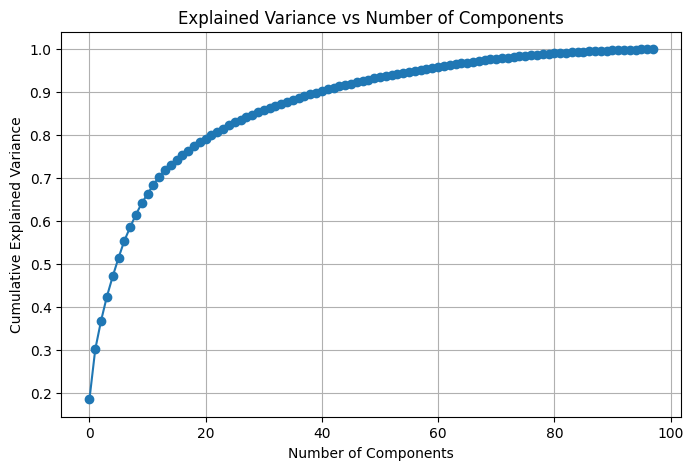

In [66]:
x_cols = [f'X{i}' for i in range(1,50)]
y_cols = [f'Y{i}' for i in range(1,50)]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.grid(True)
plt.show()

In [67]:
pca = PCA(n_components=0.95)  # Keeps enough components to explain 95% of variance
X_reduced = pca.fit_transform(X_scaled)

In [70]:
pipe_rf_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.90)),
    ('model', RandomForestRegressor(max_depth=20, max_features=None, n_estimators=200))
])

In [72]:
KFOLD_test_pipeline(pipe_rf_pca, n_splits=5, X=X_train, y=y_train)

Mean RMSE = 32376.338525187817


[33209.36409691862,
 32089.71305462255,
 33657.88971047381,
 32027.336875364374,
 30897.38888855971]